In [21]:
import os
from pathlib import Path

import emv_tools
import emv_tools.ffi.scipion as scipion
from emv_tools.ffi.blocres import blocres
from emv_tools.scipion_bridge.proxy import OutputInfo

from utils import download as D
emv_tools.scipion_bridge.environment.configure_default_env()

## Download Data

In [22]:
DOWNLOAD_PATH = Path("data/downloaded")
EMDB_ENTRY = 41510

In [42]:
metadata = D.download_emdb_metadata(entry_id=EMDB_ENTRY)

os.makedirs(DOWNLOAD_PATH, exist_ok=True)

emdb_map = D.download_emdb_map(EMDB_ENTRY, DOWNLOAD_PATH)
map_1, map_2 = D.download_halfmaps(EMDB_ENTRY, DOWNLOAD_PATH)
pdb_model = D.download_pdb_model("8tqo", DOWNLOAD_PATH) # metadata.pdb_id

metadata

EMDBMetadata(pdb_id='7l70', resolution=3.1, sampling=0.835, size=256, org_x=0, org_y=0, org_z=0)

## Create Volume from PDB

In [43]:
volume = scipion.xmipp_volume_from_pdb(
    pdb_model,
    OutputInfo(None),
    center_pdb="-v 0",
    sampling=metadata.sampling,
    size=metadata.size,
).reassign("vol")

scipion.xmipp_volume_align(
    embdb_map=str(emdb_map),
    volume=volume,
    local=True,
)

volume

[XMIPP] scipion run xmipp_volume_from_pdb -i data/downloaded/pdb8tqo.ent -o /tmp/tmpigl7p99e --centerPDB -v 0 --sampling 0.835 --size 256
Xmipp command detected
Scipion v3.7.1 - Eugenius
[XMIPP] scipion run xmipp_volume_align --i1 data/downloaded/emd_41510.map --i2 /tmp/tmpigl7p99e.vol --local --apply /tmp/tmpe9rmchev.vol
1 (1,0,0,0,0,1,0,0,0)--->-0.349795
   (1,0,***0.709587,0,0,1,0,0,0)--->-0.354899
   (1,0,0.709587,***0.889898,0,1,0,0,0)--->-0.359015
   (1,0,0.709587,0.889898,***-2.02647,1,0,0,0)--->-0.364126
   (1,0,0.709587,0.889898,-2.02647,***1.0526,0,0,0)--->-0.372631
   (1,0,0.709587,0.889898,-2.02647,1.0526,***-4.86482,0,0)--->-0.388258
   (1,0,0.709587,0.889898,-2.02647,1.0526,-4.86482,***3.64532,0)--->-0.465488
   (1,0,0.709587,0.889898,-2.02647,1.0526,-4.86482,3.64532,***2.76693)--->-0.558715
2 (1,0,0.709587,0.889898,-2.02647,1.0526,-4.86482,3.64532,2.76693)--->-0.558715
   (1,0,***2.07012,0.889898,-2.02647,1.0526,-4.86482,3.64532,2.76693)--->-0.576119
   (1,0,2.07012,***0

Output()

In [44]:
print(volume)

<ReferenceProxy for /tmp/tmpigl7p99e.vol (owned)>


### Mask from Volume

In [45]:
mask = scipion.xmipp_transform_threshold(
    volume, select="below 0.02", substitute="binarize"
)
mask = scipion.xmipp_transform_morphology(mask, binary_operation="dilation", size=2)

mask

[XMIPP] scipion run xmipp_transform_threshold -i /tmp/tmpigl7p99e.vol -o /tmp/tmptnrgkil1.vol --select below 0.02 --substitute binarize
Input File: /tmp/tmpigl7p99e.vol
Output File: /tmp/tmptnrgkil1.vol
Xmipp command detected
Scipion v3.7.1 - Eugenius
[XMIPP] scipion run xmipp_transform_morphology -i /tmp/tmptnrgkil1.vol -o /tmp/tmpnfi1vqjq.vol --binaryOperation dilation --size 2
Input File: /tmp/tmptnrgkil1.vol
Output File: /tmp/tmpnfi1vqjq.vol
Initially the image has 487083 pixels set to 1
Finally the image has 646612 pixels set to 1
Xmipp command detected
Scipion v3.7.1 - Eugenius


Output()

In [46]:
def apply_sampling(data, sampling):
    data = scipion.xmipp_image_convert(data)
    scipion.xmipp_image_header(data, sampling=sampling)

    return data

volume = apply_sampling(volume, metadata.sampling)
mask = apply_sampling(mask, metadata.sampling)

[XMIPP] scipion run xmipp_image_convert -i /tmp/tmpigl7p99e.vol -o /tmp/tmp6h9la6qa.mrc -t vol
Input File: /tmp/tmpigl7p99e.vol
Output File: /tmp/tmp6h9la6qa.mrc
Xmipp command detected
Scipion v3.7.1 - Eugenius
[XMIPP] scipion run xmipp_image_header -i /tmp/tmp6h9la6qa.mrc -s 0.835
Input File: /tmp/tmp6h9la6qa.mrc
New sampling rate (Angstrom) = 0.835
Xmipp command detected
Scipion v3.7.1 - Eugenius
[XMIPP] scipion run xmipp_image_convert -i /tmp/tmpnfi1vqjq.vol -o /tmp/tmpsgr48k53.mrc -t vol
Input File: /tmp/tmpnfi1vqjq.vol
Output File: /tmp/tmpsgr48k53.mrc
Xmipp command detected
Scipion v3.7.1 - Eugenius
[XMIPP] scipion run xmipp_image_header -i /tmp/tmpsgr48k53.mrc -s 0.835
Input File: /tmp/tmpsgr48k53.mrc
New sampling rate (Angstrom) = 0.835
Xmipp command detected
Scipion v3.7.1 - Eugenius


## Compute BlocRes

In [62]:
blocres_half = blocres(
    str(map_1),
    str(map_2),
    mask=mask,
    sampling=f"{metadata.sampling},{metadata.sampling},{metadata.sampling}",
    box=int(metadata.resolution * 5),
    cutoff=0.5,
    step=1,
    verbose=1,
)

[BlocRes] /home/max/scipion3/software/em/bsoft/bin/blocres  -Mask /tmp/tmpsgr48k53.mrc -sampling 0.835,0.835,0.835 -box 15 -cutoff 0.5 -nofill -smooth -pad 1 -step 1 -maxresolution 0.5 -verbose 1 data/downloaded/emd_41510_half_map_1.map data/downloaded/emd_41510_half_map_2.map /tmp/tmpjz1ul2ic.map
# /home/max/scipion3/software/em/bsoft/bin/blocres -Mask /tmp/tmpsgr48k53.mrc -sampling 0.835,0.835,0.835 -box 15 -cutoff 0.5 -nofill -smooth -pad 1 -step 1 -maxresolution 0.5 -verbose 1 data/downloaded/emd_41510_half_map_1.map data/downloaded/emd_41510_half_map_2.map /tmp/tmpjz1ul2ic.map 
# Thu Jul 10 17:01:42 2025


Calculating local resolution:
Mask:                           /tmp/tmpsgr48k53.mrc (-1)
Kernel size:                    15
Step size:                      1
Edge size:                      7	7	7
Padding size:                   30
Smoothing/tapering:             2
Cutoff(s):                      0.500

Boxes to calculate:             646612



KeyboardInterrupt: 

In [48]:
import shutil

shutil.copy(blocres_half.path, f"data/results/blocres-halfmap-{EMDB_ENTRY}.map")

'data/results/blocres-halfmap-41510.map'

In [49]:
atomic_model = scipion.xmipp_pdb_label_from_volume(
    pdb=str(pdb_model),
    volume=blocres_half,
    mask=mask,
    sampling=metadata.sampling,
    origin="%f %f %f" % (metadata.org_x, metadata.org_y, metadata.org_z),
)

[XMIPP] scipion run xmipp_pdb_label_from_volume -o /tmp/tmpj4i5hxpk.atom.pdb --pdb data/downloaded/pdb8tqo.ent --vol /tmp/tmpn7uaj60n.map --mask /tmp/tmpsgr48k53.mrc --sampling 0.835 --origin 0.000000 0.000000 0.000000
PDB file:           data/downloaded/pdb8tqo.ent
Output:       /tmp/tmpj4i5hxpk.atom.pdb
Sampling rate:        0.835
Origin:               0.000000 0.000000 0.000000 
Radius:               0.8
mean value: = 0.380183
absolute mean value: = 0.380183
Xmipp command detected
Scipion v3.7.1 - Eugenius


In [50]:
# blocres_model = blocres(
#     str(emdb_map),
#     volume,
#     mask=mask,hist
#     sampling=f"{metadata.sampling},{metadata.sampling},{metadata.sampling}",
#     box=int(metadata.resolution * 5),
#     cutoff=0.67,
#     step=1,
# )

In [51]:
import shutil

shutil.copy(atomic_model.path, f"data/results/atomic_model_emd-{EMDB_ENTRY}.pdb")

'data/results/atomic_model_emd-41510.pdb'

In [52]:
shutil.copy

<function shutil.copy(src, dst, *, follow_symlinks=True)>

## Compute FSCQ

In [53]:
# fscq_diff = scipion.xmipp_image_operate(blocres_model, minus=blocres_half)
# atomic_model = scipion.xmipp_pdb_label_from_volume(
#     pdb=str(pdb_model),
#     volume=fscq_diff,
#     mask=mask,
#     sampling=metadata.sampling,
#     origin="%f %f %f" % (metadata.org_x, metadata.org_y, metadata.org_z),
# )

In [54]:
with open(atomic_model.path) as f:
    print(f.read())

ATOM      1 N    PRO A  41      78.900  92.740  94.761  0.00 94.55           N  
ATOM      2 CA   PRO A  41      78.553  91.803  95.835  1.18 99.13           C  
ATOM      3 C    PRO A  41      78.866  92.361  97.219  1.15 98.75           C  
ATOM      4 O    PRO A  41      79.846  93.091  97.370  0.00 95.82           O  
ATOM      5 CB   PRO A  41      79.426  90.582  95.530  0.00 95.42           C  
ATOM      6 CG   PRO A  41      79.678  90.659  94.065  0.00 91.77           C  
ATOM      7 CD   PRO A  41      79.774  92.122  93.749  1.74 90.94           C  
ATOM      8 N    PRO A  42      78.041  92.028  98.212  1.07 88.79           N  
ATOM      9 CA   PRO A  42      78.300  92.510  99.576  0.00 86.24           C  
ATOM     10 C    PRO A  42      79.592  91.923 100.124  1.01 84.76           C  
ATOM     11 O    PRO A  42      79.842  90.721 100.012  0.77 85.46           O  
ATOM     12 CB   PRO A  42      77.077  92.024 100.364  1.54 81.81           C  
ATOM     13 CG   PRO A  42  

In [55]:
# !scipion run xmipp_transform_threshold

(array([7.801e+04, 2.506e+03, 9.900e+01, 2.400e+01, 1.600e+01, 2.500e+01,
        2.600e+01, 3.800e+01, 4.000e+01, 1.240e+02]),
 array([ 2.47576809,  7.23819113, 12.00061417, 16.76303673, 21.52545929,
        26.28788376, 31.05030632, 35.81272888, 40.57515335, 45.33757401,
        50.09999847]),
 <BarContainer object of 10 artists>)

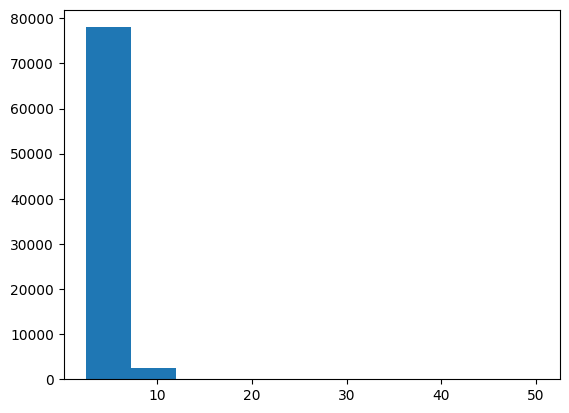

In [58]:
import xmippLib as X
import matplotlib.pyplot as plt
import numpy as np

res_map = X.Image("data/results/blocres-halfmap-41510.map").getData()
res_map = np.reshape(res_map, [-1])
res_map = res_map[res_map > 0]

plt.hist(res_map)

(array([2.67887e+05, 1.44294e+05, 7.01640e+04, 4.83940e+04, 3.08970e+04,
        1.77590e+04, 6.31300e+03, 8.34000e+02, 1.15000e+02, 9.00000e+00]),
 array([2.75466609, 3.29383469, 3.83300328, 4.37217188, 4.91134024,
        5.45050907, 5.98967743, 6.52884626, 7.06801462, 7.60718346,
        8.14635181]),
 <BarContainer object of 10 artists>)

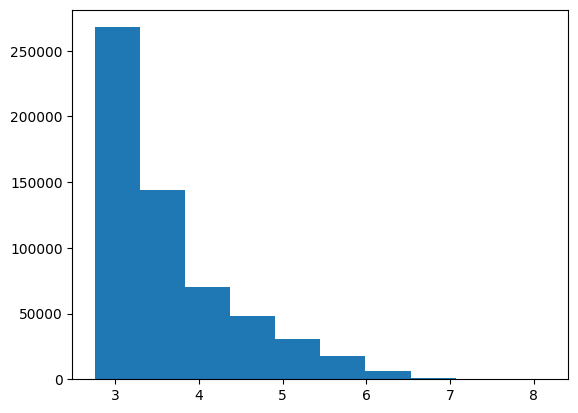

In [60]:
res_map = X.Image("/home/max/Documents/val-server/data/val-report-service/EMD-41510/EMD-41510_ScipionProject/Runs/001132_BsoftProtBlocres/extra/resolutionMap.map").getData()
res_map = np.reshape(res_map, [-1])
res_map = res_map[res_map > 0]

plt.hist(res_map)